# 🧠 Selección y extracción de Características  

En esta fase se busca **reducir la dimensionalidad** del conjunto de datos y conservar únicamente aquellas características más relevantes para la tarea de clasificación binaria (*imagen manipulada* vs *imagen no manipulada*).  

Tras la extracción de características (Fase 02), cada imagen fue representada mediante un vector de **n atributos**, incluyendo descriptores como HOG, GLCM, LBP, entre otros. Sin embargo, no todas estas variables aportan información útil al modelo; algunas pueden ser redundantes o incluso introducir ruido.  

Por esta razón, se implementaron **tres estrategias complementarias de selección de características**:  

---

## ✅ Métodos Utilizados  

### 1️⃣ Análisis de Varianza (ANOVA) - F-Score
- Este método estadístico evalúa la capacidad discriminativa de cada característica individualmente, comparando la varianza **entre clases** con la varianza **dentro de la misma clase**.

---

### 2️⃣ Recursive Feature Elimination (RFE)  
- RFE utiliza un modelo de machine learning (RF en este caso) para evaluar la importancia de las características y eliminar de forma recursiva aquellas menos relevantes.

---

### 3️⃣ Análisis de Componentes Principales (PCA)  
- PCA no es estrictamente un método de selección, sino de **reducción de dimensionalidad**.  
- Se proyectaron las características en un espacio de menor dimensión, manteniendo las componentes principales que explican la mayor varianza del conjunto de datos.  
- Esta técnica es especialmente útil para eliminar colinealidad entre atributos y acelerar el entrenamiento de los modelos.  

---

## 🎯 Resultado Esperado  
Al finalizar esta fase:  
✅ Se obtendrá un conjunto reducido de características relevantes.  
✅ Se almacenará en un archivo `data_reduced.npz` para su uso en la fase siguiente (*entrenamiento y validación de modelos*).  
✅ Esto permitirá construir modelos más ligeros, con mejor generalización y menor riesgo de sobreajuste.  

---

📂 **Output de la Fase 03**  
- NPZ con características seleccionadas (`data_reduced.npz`).  
- Gráficos de importancia de variables y varianza explicada.  

In [22]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [23]:

def select_features_filter(X, y, feature_names, k=20, plot=True):
 
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    mask = selector.get_support()  # True para características seleccionadas
    
    # F-scores
    f_scores = pd.Series(selector.scores_, index=feature_names)
    f_scores_sorted = f_scores.sort_values(ascending=False)
    
    # Características seleccionadas
    selected_features = f_scores_sorted.index[:k].tolist()
    
    if plot:
        plt.figure(figsize=(10, 5))
        f_scores_sorted.plot(kind='bar', color='skyblue')
        plt.title("Importancia de las características (ANOVA F-score)")
        plt.ylabel("F-score")
        plt.xlabel("Características")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    return X_new, selected_features, f_scores_sorted

def rfe_with_random_forest(X, y, n_features_to_select=10, test_size=0.2, random_state=42, plot=True):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Modelo base Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)

    # Aplicar RFE
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Variables seleccionadas
    selected_features = X.columns[rfe.support_].tolist()
    print("📌 Características seleccionadas:", selected_features)

    # Entrenar modelo RF sobre las características seleccionadas
    rf.fit(X_train[selected_features], y_train)

    # Evaluar
    y_pred = rf.predict(X_test[selected_features])
    y_prob = rf.predict_proba(X_test[selected_features])[:, 1]
    print("📊 Reporte de clasificación:\n", classification_report(y_test, y_pred))

    if plot:
        # 🎨 Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
        plt.title("Matriz de Confusión")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # 🎨 Curva ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("Curva ROC")
        plt.xlabel("Tasa de Falsos Positivos")
        plt.ylabel("Tasa de Verdaderos Positivos")
        plt.legend()
        plt.show()

        # 🎨 Importancia de características
        importances = pd.Series(rf.feature_importances_, index=selected_features)
        importances = importances.sort_values()
        plt.figure(figsize=(8, 5))
        importances.plot(kind="barh", color="green")
        plt.title("Importancia de características (Random Forest)")
        plt.xlabel("Importancia")
        plt.show()

    return selected_features, rf


def reduce_with_pca(X, n_components=20):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

In [24]:
data = np.load("data.npz")

X = data['X']
y = data['y']
grupos = data['groups']

In [25]:
data = np.load("data.pkl", allow_pickle=True)

X = data.drop(columns=['uuid', 'label'])
y = data['label'].values

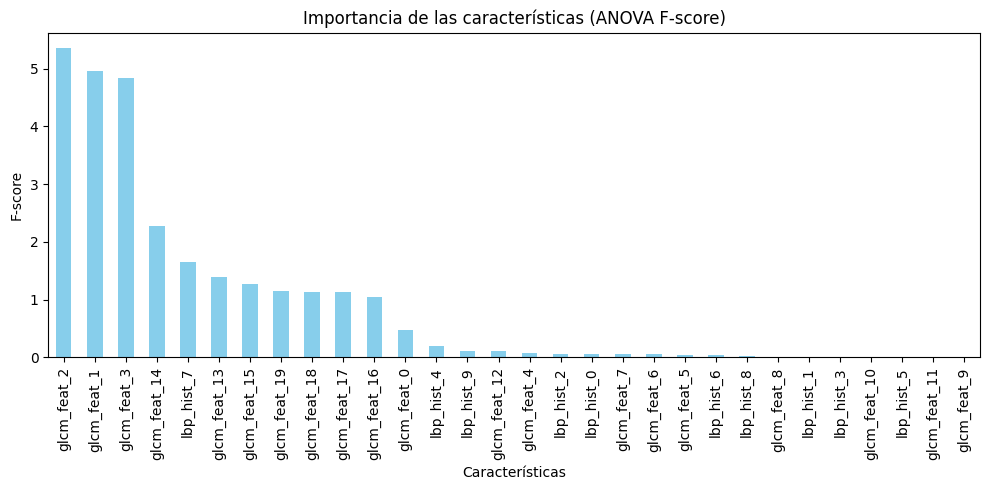

📌 Características seleccionadas: ['lbp_hist_0', 'lbp_hist_2', 'lbp_hist_3', 'lbp_hist_4', 'lbp_hist_5', 'lbp_hist_6', 'lbp_hist_7', 'lbp_hist_8', 'lbp_hist_9', 'glcm_feat_0', 'glcm_feat_1', 'glcm_feat_2', 'glcm_feat_3', 'glcm_feat_12', 'glcm_feat_13', 'glcm_feat_14', 'glcm_feat_15', 'glcm_feat_16', 'glcm_feat_17', 'glcm_feat_18']
📊 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.58      0.72        31
           1       0.84      0.99      0.91        68

    accuracy                           0.86        99
   macro avg       0.89      0.78      0.81        99
weighted avg       0.87      0.86      0.85        99



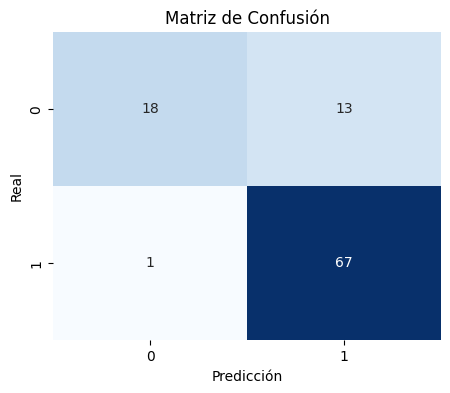

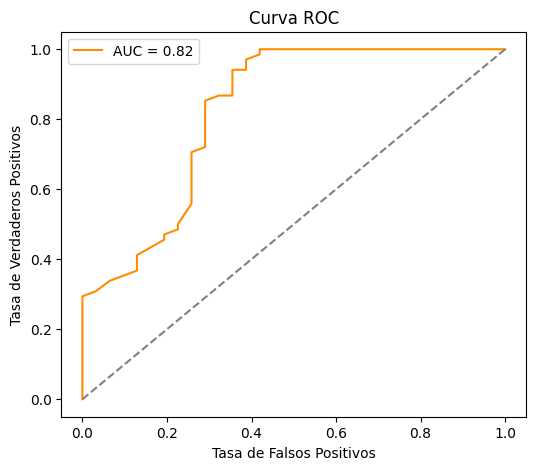

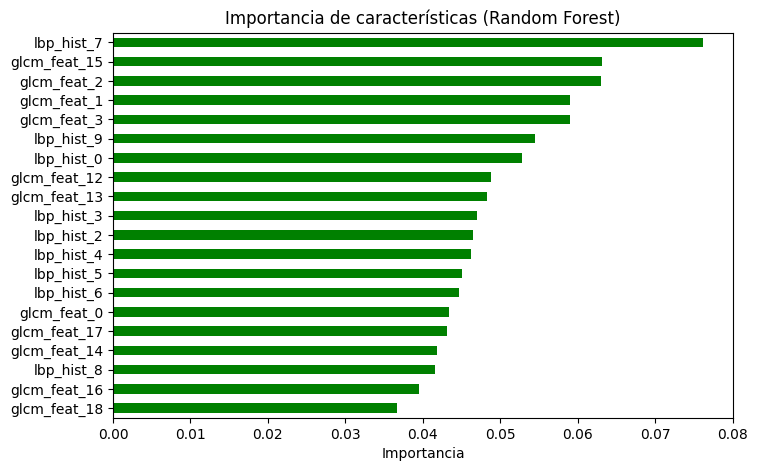

In [26]:
comp = X.shape[1]//2
X_new, mask, _ = select_features_filter(X=X.values, y=y, feature_names=X.columns, k=comp, plot=True)
X_rfe, rf_model = rfe_with_random_forest(X, y, n_features_to_select=20, plot=True)

#X_pca, pca = reduce_with_pca(X, n_components=comp)